In [1]:
import numpy as np
import pymc as pm
from pytensor.tensor import TensorVariable

def logp(value: TensorVariable, mu: TensorVariable) -> TensorVariable:
    return -(value - mu)**2

with pm.Model():
    mu = pm.Normal('mu',0,1)
    pm.CustomDist(
        'custom_dist',
        mu,
        logp=logp,
        observed=np.random.randn(100),
    )
    idata = pm.sample(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

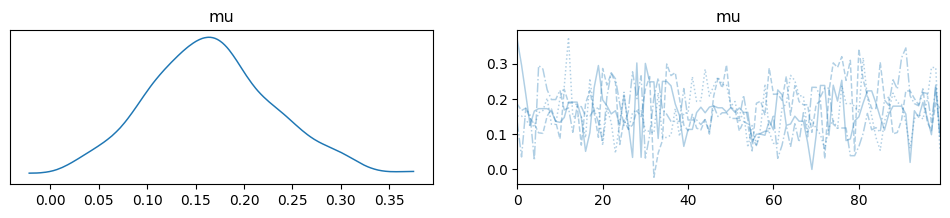

In [2]:
import arviz as az

ax = az.plot_trace(idata, combined=True)
ax

In [6]:
print(type(pm.Normal.dist()))
print(type(pm.Normal.dist() + pm.Normal.dist()))
print(type(pm.Normal.dist() * pm.Normal.dist()))
with pm.Model():
    print(type(pm.Normal('x')))

<class 'pytensor.tensor.var.TensorVariable'>
<class 'pytensor.tensor.var.TensorVariable'>
<class 'pytensor.tensor.var.TensorVariable'>
<class 'pytensor.tensor.var.TensorVariable'>


In [48]:
import pytensor

s = 'a'
s_pt = pytensor.shared(s)
s_pt.type
print(dir(s_pt))
print(type(s_pt.get_value()))

d = {'a': 1}
d[s_pt.get_value()]

['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__count__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__repr_test_value__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_default_update', '_index', '_is_protocol', '_owner', 'auto_name', 'clone', 'container', 'default_update', 'eval', 'get_parents', 'get_test_value', 'get_value', 'index', 'name', 'owner', 'set_value', 'tag', 'type']
<class 'str'>


1

In [60]:
from pytensor.tensor import TensorVariable
from pytensor.compile.sharedvalue import SharedVariable
print(dir(TensorVariable))
print(dir(SharedVariable))

['T', '__abs__', '__abstractmethods__', '__add__', '__and__', '__annotations__', '__array_priority__', '__bool__', '__ceil__', '__class__', '__class_getitem__', '__count__', '__delattr__', '__dict__', '__dir__', '__div__', '__divmod__', '__doc__', '__dot__', '__eq__', '__floor__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__invert__', '__iter__', '__le__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__orig_bases__', '__parameters__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__rdivmod__', '__rdot__', '__reduce__', '__reduce_ex__', '__repr__', '__repr_test_value__', '__rfloordiv__', '__rmatmul__', '__rmod__', '__rmul__', '__ror__', '__rpow__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__trunc__', '__weakref__', '__xor__', '

In [84]:
d = 2
a = np.array([0, 1, 2])

class Site:
    def __init__(self, a):
        self.a = a
    def set_a(self, new_a):
        self.a = new_a

vSite = np.vectorize(Site)

init_arry = np.arange(9).reshape((3,3))

lattice = np.empty((3,3), dtype=object)
lattice[:,:] = vSite(init_arry)



def logp(value: TensorVariable, d_pt: TensorVariable, a_pt: TensorVariable, lattice_pt: TensorVariable, x: TensorVariable):
    print(type(x))
    return -(value - a_pt[d_pt] - x) ** 2

with pm.Model() as model:
    x = pm.Normal('x', 0, 1)
    pm.CustomDist(
        'costum',
        d, 
        a,
        lattice,
        x,
        logp=logp,
        observed=np.random.normal(loc=1, size=100)
    )

    idata = pm.sample(1000)

TypeError: Unsupported dtype for TensorType: object

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

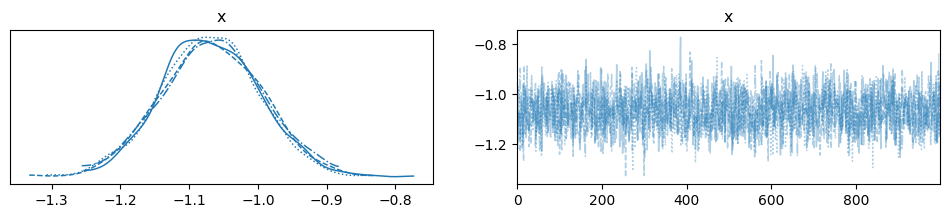

In [76]:
az.plot_trace(idata)

ImportError: cannot import name 'TensorSharedVariable' from 'pytensor.tensor' (/home/ominusliticus/python_venvs/pymc5_venv/lib/python3.10/site-packages/pytensor/tensor/__init__.py)

# Playing with Mixtures

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

In [13]:
# Practice with global model mixing first
number_model = 2
model_location = 10
model_uncertainty = 1
true_location = -10
true_uncertainty = 0.5

RANDOM_SEED = 6666
y_obs = np.random.normal(loc=true_location, scale=true_uncertainty, size=100).reshape(25, 4)
with pm.Model() as model:
    models = pm.Normal.dist(
        mu=pm.math.stack([-model_location, model_location]),
        sigma=model_uncertainty,
        shape=(3,)
    )
    
    shape_parameters = pm.LogNormal('shape_parameters', mu=0.0, sigma=1.0, shape=2)
    weights = pm.Dirichlet('weights', a=shape_parameters)
    
    likelihood = pm.Mixture('likelihood', w=weights, comp_dists=models, observed=y_obs)
    
    example_data = pm.sample(
        draws=1_000,
        tune=1_000,
        target_accept=0.90,
        return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [shape_parameters, weights]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


(array([3988.,   12.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 [<matplotlib.patches.Polygon at 0x7fa75c56fd90>])

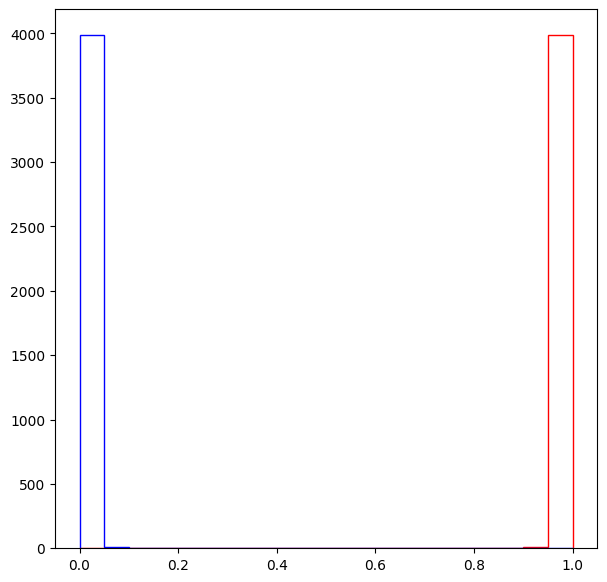

In [14]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 7))
ax.patch.set_facecolor('white')
bins=20
ranges=(0,1)
ax.hist(example_data.posterior['weights'].to_numpy().reshape(-1,2)[:,0], histtype='step', color='red', bins=bins, range=ranges)
ax.hist(example_data.posterior['weights'].to_numpy().reshape(-1,2)[:,1], histtype='step', color='blue', bins=bins, range=ranges)

In [21]:
a= np.linspace(1, 10, 10).reshape(-1,1)
a.ndim

2

In [6]:
import numpy as np

a = np.arange(0, 27).reshape(3, 3, 3)
a

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

In [7]:
a.flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])